In [19]:
import sys 
sys.path.append("../")
import pandas as pd 
import numpy as np 
import ta
from backtester import *

In [20]:
data = pd.read_csv('../forex_prices/m5/EUR_USD_m5.csv', index_col=['date'], parse_dates=['date'])
columns = ['open', 'high', 'low', 'close']
for col in columns:
    data[col] = data[['bid'+col, 'ask'+col]].mean(axis=1)
display(data.head())
print(data.shape)

,bidopen,bidclose,bidhigh,bidlow,askopen,askclose,askhigh,asklow,tickqty,open,high,low,close
date,,,,,,,,,,,,,
2021-07-21 12:35:00,1.17674,1.17632,1.17677,1.17626,1.17686,1.17645,1.17688,1.17638,878,1.176800,1.176825,1.176320,1.176385
2021-07-21 12:40:00,1.17632,1.17625,1.17646,1.17614,1.17645,1.17638,1.17658,1.17625,1104,1.176385,1.176520,1.176195,1.176315
2021-07-21 12:45:00,1.17625,1.17594,1.17625,1.17594,1.17638,1.17606,1.17638,1.17606,1328,1.176315,1.176315,1.176000,1.176000
2021-07-21 12:50:00,1.17594,1.17637,1.17672,1.17591,1.17606,1.17650,1.17685,1.17603,1301,1.176000,1.176785,1.175970,1.176435
2021-07-21 12:55:00,1.17637,1.17654,1.17663,1.17614,1.17650,1.17667,1.17675,1.17626,1311,1.176435,1.176690,1.176200,1.176605


(10000, 13)


In [21]:
window = 14
data['rsi'] = ta.momentum.rsi(data['close'], window=window, fillna=False)
data.dropna(inplace=True)
display(data.head())
print(data.shape)

,bidopen,bidclose,bidhigh,bidlow,askopen,askclose,askhigh,asklow,tickqty,open,high,low,close,rsi
date,,,,,,,,,,,,,,
2021-07-21 13:40:00,1.17747,1.17817,1.17823,1.17739,1.17759,1.17829,1.17835,1.17751,1812,1.177530,1.178290,1.177450,1.178230,80.849820
2021-07-21 13:45:00,1.17817,1.17831,1.17834,1.17807,1.17829,1.17843,1.17846,1.17820,1847,1.178230,1.178400,1.178135,1.178370,81.861175
2021-07-21 13:50:00,1.17831,1.17864,1.17880,1.17833,1.17843,1.17877,1.17894,1.17843,2167,1.178370,1.178870,1.178380,1.178705,84.034016
2021-07-21 13:55:00,1.17864,1.17867,1.17879,1.17844,1.17877,1.17879,1.17890,1.17856,1690,1.178705,1.178845,1.178500,1.178730,84.186257
2021-07-21 14:00:00,1.17867,1.17838,1.17869,1.17815,1.17879,1.17851,1.17881,1.17827,1875,1.178730,1.178750,1.178210,1.178445,75.363793


(9987, 14)


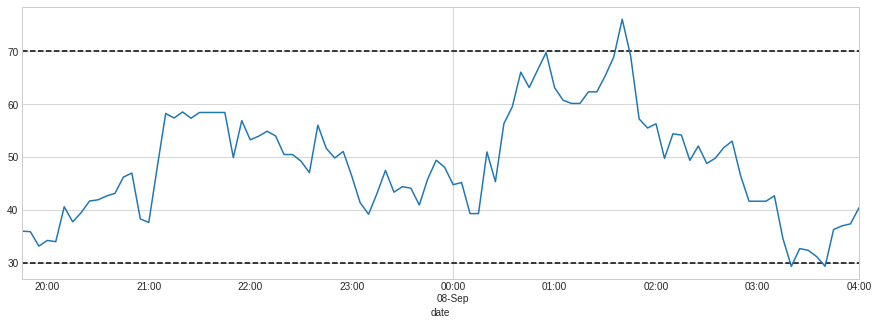

In [22]:
data['rsi'].iloc[-100:].plot(figsize=(15,5))
plt.hlines(y=70, xmin=data.index[0], xmax=data.index[-1], colors='k', linestyles='--')
plt.hlines(y=30, xmin=data.index[0], xmax=data.index[-1], colors='k', linestyles='--')
plt.show()

In [23]:
# strategy
# RSI >= 70 --> short
# RSI <= 30 --> long
# data['rsi_signal'] = np.where(data['rsi'] >= 70, -1, np.where(data['rsi'] <= 30, 1, 0))
data['rsi_signal'] = np.where(data['rsi'] >= 70, -1, np.where(data['rsi'] <= 30, 1, np.nan))
data['rsi_signal'] = data['rsi_signal'].ffill().fillna(0)
print('Positions')
print(data['rsi_signal'].value_counts())
print('-'*50)
print('Position changes')
print(data['rsi_signal'].diff().apply(np.abs).value_counts())

Positions
-1.0    5173
 1.0    4814
Name: rsi_signal, dtype: int64
--------------------------------------------------
Position changes
0.0    9909
2.0      77
Name: rsi_signal, dtype: int64


In [24]:
backtest = IterativeBacktester(data, data['rsi_signal'], 'm5')

In [25]:
backtest.backtest()

  0%|          | 0/9986 [00:00<?, ?it/s]

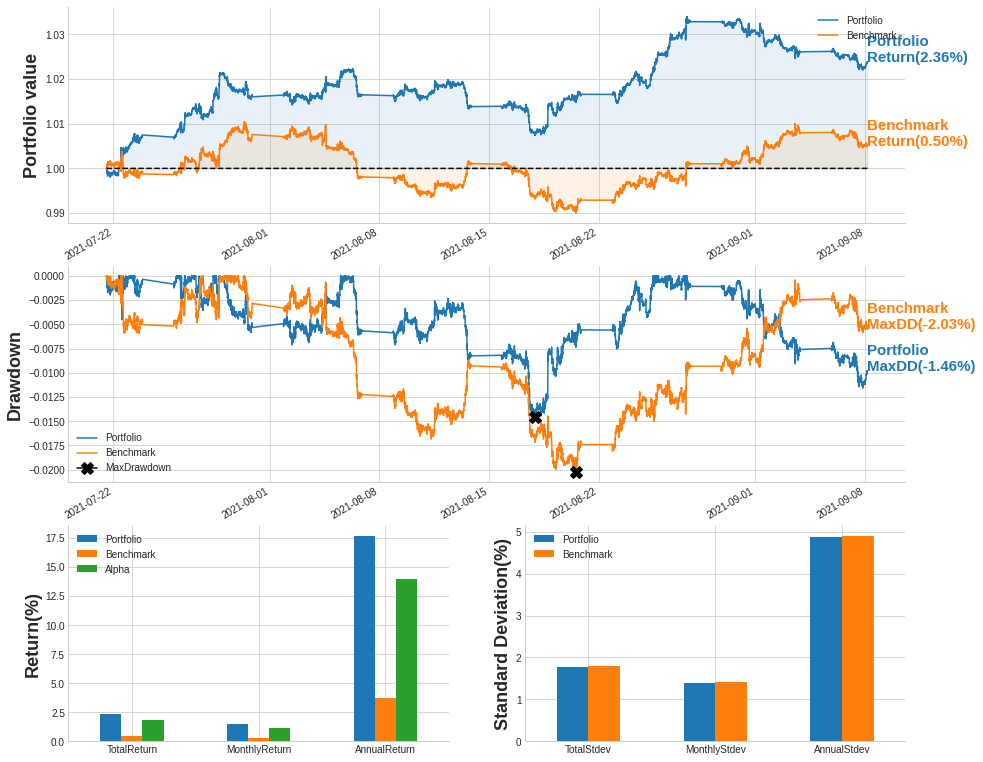

----------------------------------------------------------------------
Data length: |48 days 14:20:00|
Data range from |2021-07-21 13:40:00| to |2021-09-08 04:00:00|
----------------------------------------------------------------------
***** Portfolio Returns in percentage(%) *****
╒═══════════════╤═════════════╤═════════════╤═════════╕
│               │   Portfolio │   Benchmark │   Alpha │
╞═══════════════╪═════════════╪═════════════╪═════════╡
│ TotalReturn   │       2.359 │       0.496 │   1.863 │
├───────────────┼─────────────┼─────────────┼─────────┤
│ MonthlyReturn │       1.456 │       0.306 │   1.150 │
├───────────────┼─────────────┼─────────────┼─────────┤
│ AnnualReturn  │      17.719 │       3.726 │  13.993 │
╘═══════════════╧═════════════╧═════════════╧═════════╛
***** Portfolio Standard Deviation in percentage(%) *****
╒══════════════╤═════════════╤═════════════╕
│              │   Portfolio │   Benchmark │
╞══════════════╪═════════════╪═════════════╡
│ TotalStdev   │   

In [26]:
backtest.results()